# Libraries

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
# %matplotlib widget    # interactive 3d plots
from sklearn.svm import SVC
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import data_loader
import model_evaluation
import plotting_utils
import model_training
from sklearn import linear_model
from sklearn import metrics
import copy
from mv_utils import lasso_rank, SVM_eval
# from tqdm import tqdm

/home/vrtx26/.local/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Feature (MFCC) extraction (Dataset generation)

In [3]:
# run this function if you need to generate a csv data set from scratch
X, y, ID = data_loader.load_dataset(should_generate_dataset=True, 
                                    use_vad=False, 
                                    use_delta_mfcc=False,
                                    use_delta_delta_mfcc=True)

{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}
INFO: n_fft=16384, n_mfcc=34
{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}


0it [00:00, ?it/s]

--- Data loaded. Loading time: 0.003998756408691406 seconds ---
X.shape =  (0, 0)
y.shape =  (0, 0)
ID.shape =  (0, 0)
data loaded in 0.010998964309692383ms
Empty DataFrame
Columns: []
Index: []
X.shape =  (0, 0)
X.columns =  Index([], dtype='object')


# Loading Dataset

In [10]:
X, y, ID = data_loader.load_dataset(X_path='data/2023-11-08/feature_mfcc_34_delta_delta_nfft_4096.csv', 
                                    y_path='data/2023-11-08/y_labels_feature_34_mfcc_delta_delta_nfft_4096.csv',
                                    ID_path='data/2023-11-08/IDs_feature_mfcc_34_delta_delta_nfft_4096.csv') 

data loaded in 0.07634496688842773ms
          0         1         2         3         4         5         6  \
0  0.327805 -0.464719 -0.540320 -0.983787 -1.276392 -0.517576 -0.059207   
1 -0.483202 -0.287426  0.073267 -0.259939 -1.043461  0.220426 -0.243781   
2 -0.982079  1.092156 -0.237941 -0.002997 -0.934974  0.313563  0.708375   
3  0.968642 -1.604765 -0.123183 -0.789169 -1.783557 -0.222486 -0.352760   
4  0.548607 -1.485735 -0.842989 -0.959707 -1.563772 -0.373401 -0.273213   

          7         8         9  ...       296       297       298       299  \
0 -1.325718 -0.865250 -1.400271  ... -0.000500  0.245232  0.467592  0.179897   
1 -0.745799 -0.558315 -0.667095  ...  0.081401 -0.156604  0.054227  1.335473   
2  0.392641 -0.112142 -0.675854  ...  1.159202 -0.281807  0.370446  0.969862   
3 -1.354752 -0.871037 -0.944073  ... -0.582348  1.606737 -1.213523  0.283672   
4 -1.374351 -0.530736 -0.333489  ... -0.312877 -1.016252 -0.713702  0.537837   

        300       301       302

## Relabeling and normilizing

In [11]:
y_true = np.zeros((len(y)))
y_true[np.squeeze(y.values=='surprised')] = 1
y_true[y_true==0] = -1

X_data = X.values
X_norm = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)
y_reg = copy.copy(y_true)

# LASSO ranking

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.627e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.595e+02, tolerance: 6.656e-02

Text(0, 0.5, 'Coeffs')

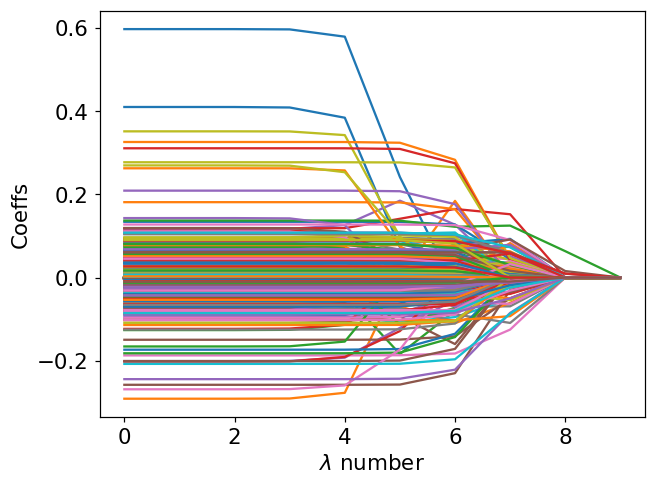

In [12]:
Lasso_model = linear_model.Lasso()
Npt = 10
coeffs = np.zeros((X_norm.shape[1],Npt))
lambda_ = np.logspace(-12.0, 0.5, Npt)
i = 0
for lamb in lambda_:
    Lasso_model = linear_model.Lasso(alpha=lamb, max_iter=20000)
    Lasso_model.fit(X_norm,y_reg)
    coeffs[:,i] = Lasso_model.coef_
    i = i + 1

plt.figure(dpi=110)
plt.plot(coeffs.T)
plt.xlabel('$\lambda$ number')
plt.ylabel('Coeffs')

In [13]:
Rank_lasso = []
for i in range(coeffs.shape[1]-1,-1,-1):
    withdraw_features = np.nonzero(coeffs[:,i])[0];
    something_new = np.setdiff1d(withdraw_features, Rank_lasso)
    if len(something_new):
        for ii in range(len(something_new)):
            Rank_lasso.append(something_new[ii])

In [14]:
np.save('data/Lasso_Ranking_surprised_result.npy', Rank_lasso)    # .npy extension is added if not given
Rank_lasso = np.load('data/Lasso_Ranking_surprised_result.npy')

# LOSO accuracy estimation

Iter =  1  AUC = 0.6855
Iter =  4  AUC = 0.7380
Iter =  6  AUC = 0.7584
Iter =  9  AUC = 0.7618
Iter =  10  AUC = 0.7646
Iter =  37  AUC = 0.7656
Iter =  39  AUC = 0.7863
Iter =  40  AUC = 0.7979
Iter =  43  AUC = 0.7987
Iter =  44  AUC = 0.8057
Iter =  56  AUC = 0.8165
Iter =  58  AUC = 0.8193
Iter =  59  AUC = 0.8247
Iter =  62  AUC = 0.8249
Iter =  64  AUC = 0.8341
auc_best = 0.83413462


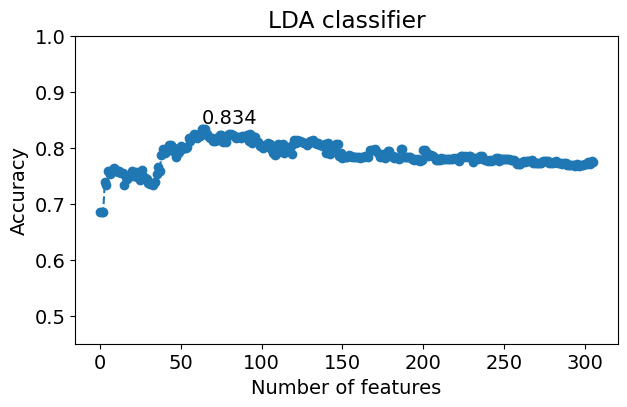

In [15]:
# Rank = lasso_rank(X,y)
# Rank = np.array(Rank)

# subj_IDs = np.squeeze(ID.values)

Rank = Rank_lasso
auc_svm = []
auc_best = 0
ind_best = 0
for k in range(1,len(Rank)+1):
    feature_inds = Rank[:k]
    auc = SVM_eval(X_norm,y_reg, feature_inds, ID)    
    auc_svm.append(auc)
    if (auc>auc_best):
        auc_best = auc
        ind_best = k-1
        print('Iter = ', k, f' AUC = {auc:.4f}' )
    
fig,ax=plt.subplots(figsize=(7,4),dpi=100)
plt.rcParams.update({'font.size': 14})
plt.plot(auc_svm,marker='o', linestyle='dashed')
plt.text(ind_best, auc_best+0.01, f'{auc_best:.3f}')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('LDA classifier')
plt.ylim([0.45, 1.00])

print(f'auc_best = {auc_best:.8f}')

# image_name = 'figures\\ACC_LDA_vowel_a.jpg'
# fig.savefig(image_name, bbox_inches='tight', pad_inches = 0.2)

In [17]:
print('best auc (LDA) = ', np.max(auc_svm), 'Number of features = ', np.argmax(auc_svm))

best auc (LDA) =  0.8341346153846154 Number of features =  63


# Backward step selection

In [18]:
def back_step_selection_loso(X,y,feature_ind, ID):
# BACK_STEP_SELECTION Automatic procedure of feature selection

#basic version
   acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
   some_feature_droped = True
   while (some_feature_droped):
      print('NEW ROUND')
      acc_up = -np.ones_like(feature_ind)
      for i in range(len(feature_ind)):
         cur_inds = np.setdiff1d(feature_ind,feature_ind[i])
         acc_mu = SVM_eval(X,y,cur_inds, ID)
         
         print(f'Iter #{i}: {acc_mu:.3f} <-> {acc_mu_curr:.3f}')
         
         if (acc_mu>=acc_mu_curr):
            acc_up[i] = acc_mu-acc_mu_curr
      m_val = np.max(acc_up)
      m_ind = np.argmax(acc_up)
      
      if (m_val>=0):
         print(f'Withdraw feature #{m_ind}, added accracy {m_val}')
         feature_ind = np.setdiff1d(feature_ind,feature_ind[m_ind]);
         some_feature_droped = True       
         # new basic version
         acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
      else:
         acc_final = acc_mu_curr
         some_feature_droped = False

   return acc_final, feature_ind

In [19]:
ind_best = np.argmax(auc_svm)
[acc_final,feature_ind] = back_step_selection_loso(X_norm, y_reg, Rank[:ind_best+1],ID)

NEW ROUND
Iter #0: 0.835 <-> 0.834
Iter #1: 0.835 <-> 0.834
Iter #2: 0.835 <-> 0.834
Iter #3: 0.816 <-> 0.834
Iter #4: 0.830 <-> 0.834
Iter #5: 0.809 <-> 0.834
Iter #6: 0.818 <-> 0.834
Iter #7: 0.839 <-> 0.834
Iter #8: 0.837 <-> 0.834
Iter #9: 0.838 <-> 0.834
Iter #10: 0.836 <-> 0.834
Iter #11: 0.819 <-> 0.834
Iter #12: 0.807 <-> 0.834
Iter #13: 0.837 <-> 0.834
Iter #14: 0.810 <-> 0.834
Iter #15: 0.815 <-> 0.834
Iter #16: 0.835 <-> 0.834
Iter #17: 0.839 <-> 0.834
Iter #18: 0.835 <-> 0.834
Iter #19: 0.810 <-> 0.834
Iter #20: 0.834 <-> 0.834
Iter #21: 0.816 <-> 0.834
Iter #22: 0.815 <-> 0.834
Iter #23: 0.831 <-> 0.834
Iter #24: 0.830 <-> 0.834
Iter #25: 0.831 <-> 0.834
Iter #26: 0.830 <-> 0.834
Iter #27: 0.838 <-> 0.834
Iter #28: 0.840 <-> 0.834
Iter #29: 0.825 <-> 0.834
Iter #30: 0.839 <-> 0.834
Iter #31: 0.841 <-> 0.834
Iter #32: 0.820 <-> 0.834
Iter #33: 0.803 <-> 0.834
Iter #34: 0.837 <-> 0.834
Iter #35: 0.816 <-> 0.834
Iter #36: 0.838 <-> 0.834
Iter #37: 0.818 <-> 0.834
Iter #38: 0.

NEW ROUND
Iter #0: 0.848 <-> 0.846
Iter #1: 0.847 <-> 0.846
Iter #2: 0.842 <-> 0.846
Iter #3: 0.837 <-> 0.846
Iter #4: 0.814 <-> 0.846
Iter #5: 0.812 <-> 0.846
Iter #6: 0.817 <-> 0.846
Iter #7: 0.846 <-> 0.846
Iter #8: 0.845 <-> 0.846
Iter #9: 0.818 <-> 0.846
Iter #10: 0.847 <-> 0.846
Iter #11: 0.812 <-> 0.846
Iter #12: 0.832 <-> 0.846
Iter #13: 0.847 <-> 0.846
Iter #14: 0.803 <-> 0.846
Iter #15: 0.845 <-> 0.846
Iter #16: 0.833 <-> 0.846
Iter #17: 0.832 <-> 0.846
Iter #18: 0.853 <-> 0.846
Iter #19: 0.830 <-> 0.846
Iter #20: 0.846 <-> 0.846
Iter #21: 0.847 <-> 0.846
Iter #22: 0.829 <-> 0.846
Iter #23: 0.815 <-> 0.846
Iter #24: 0.841 <-> 0.846
Iter #25: 0.825 <-> 0.846
Iter #26: 0.845 <-> 0.846
Iter #27: 0.828 <-> 0.846
Iter #28: 0.827 <-> 0.846
Iter #29: 0.818 <-> 0.846
Iter #30: 0.816 <-> 0.846
Iter #31: 0.844 <-> 0.846
Iter #32: 0.845 <-> 0.846
Iter #33: 0.848 <-> 0.846
Iter #34: 0.848 <-> 0.846
Iter #35: 0.809 <-> 0.846
Iter #36: 0.827 <-> 0.846
Iter #37: 0.846 <-> 0.846
Iter #38: 0.

Iter #23: 0.824 <-> 0.856
Iter #24: 0.824 <-> 0.856
Iter #25: 0.838 <-> 0.856
Iter #26: 0.856 <-> 0.856
Iter #27: 0.856 <-> 0.856
Iter #28: 0.827 <-> 0.856
Iter #29: 0.827 <-> 0.856
Iter #30: 0.829 <-> 0.856
Iter #31: 0.857 <-> 0.856
Iter #32: 0.828 <-> 0.856
Iter #33: 0.831 <-> 0.856
Iter #34: 0.853 <-> 0.856
Iter #35: 0.848 <-> 0.856
Iter #36: 0.845 <-> 0.856
Iter #37: 0.855 <-> 0.856
Iter #38: 0.839 <-> 0.856
Iter #39: 0.839 <-> 0.856
Iter #40: 0.847 <-> 0.856
Iter #41: 0.853 <-> 0.856
Iter #42: 0.811 <-> 0.856
Iter #43: 0.830 <-> 0.856
Iter #44: 0.840 <-> 0.856
Iter #45: 0.829 <-> 0.856
Iter #46: 0.855 <-> 0.856
Iter #47: 0.847 <-> 0.856
Iter #48: 0.847 <-> 0.856
Iter #49: 0.856 <-> 0.856
Iter #50: 0.830 <-> 0.856
Iter #51: 0.818 <-> 0.856
Iter #52: 0.828 <-> 0.856
Iter #53: 0.851 <-> 0.856
Withdraw feature #0, added accracy 0
NEW ROUND
Iter #0: 0.836 <-> 0.857
Iter #1: 0.818 <-> 0.857
Iter #2: 0.806 <-> 0.857
Iter #3: 0.832 <-> 0.857
Iter #4: 0.824 <-> 0.857
Iter #5: 0.837 <-> 0.8

Iter #21: 0.846 <-> 0.866
Iter #22: 0.867 <-> 0.866
Iter #23: 0.867 <-> 0.866
Iter #24: 0.852 <-> 0.866
Iter #25: 0.837 <-> 0.866
Iter #26: 0.867 <-> 0.866
Iter #27: 0.854 <-> 0.866
Iter #28: 0.847 <-> 0.866
Iter #29: 0.840 <-> 0.866
Iter #30: 0.839 <-> 0.866
Iter #31: 0.847 <-> 0.866
Iter #32: 0.841 <-> 0.866
Iter #33: 0.826 <-> 0.866
Iter #34: 0.839 <-> 0.866
Iter #35: 0.841 <-> 0.866
Iter #36: 0.800 <-> 0.866
Iter #37: 0.842 <-> 0.866
Iter #38: 0.848 <-> 0.866
Iter #39: 0.838 <-> 0.866
Iter #40: 0.835 <-> 0.866
Iter #41: 0.828 <-> 0.866
Iter #42: 0.857 <-> 0.866
Iter #43: 0.866 <-> 0.866
Iter #44: 0.827 <-> 0.866
Iter #45: 0.837 <-> 0.866
Iter #46: 0.851 <-> 0.866
Iter #47: 0.834 <-> 0.866
Withdraw feature #22, added accracy 0
NEW ROUND
Iter #0: 0.828 <-> 0.867
Iter #1: 0.818 <-> 0.867
Iter #2: 0.821 <-> 0.867
Iter #3: 0.834 <-> 0.867
Iter #4: 0.841 <-> 0.867
Iter #5: 0.850 <-> 0.867
Iter #6: 0.859 <-> 0.867
Iter #7: 0.862 <-> 0.867
Iter #8: 0.853 <-> 0.867
Iter #9: 0.832 <-> 0.867


In [20]:
np.save('data/feature_idx_surprised.npy', feature_ind)    # .npy extension is added if not given
feature_ind = np.load('data/feature_idx_surprised.npy')

# 5-fold CV (full feature space)

In [21]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm)
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

## GridSearch

 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.88it/s]

UAR = 0.391


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.20it/s]

UAR = 0.419


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.75it/s]

UAR = 0.419


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.98it/s]

UAR = 0.436


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.85it/s]

UAR = 0.456


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.56it/s]

UAR = 0.454


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.56it/s]

UAR = 0.444


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.85it/s]

UAR = 0.436


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.94it/s]

UAR = 0.429


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


UAR = 0.423
UAR_best = 0.456, C_best = 0.004


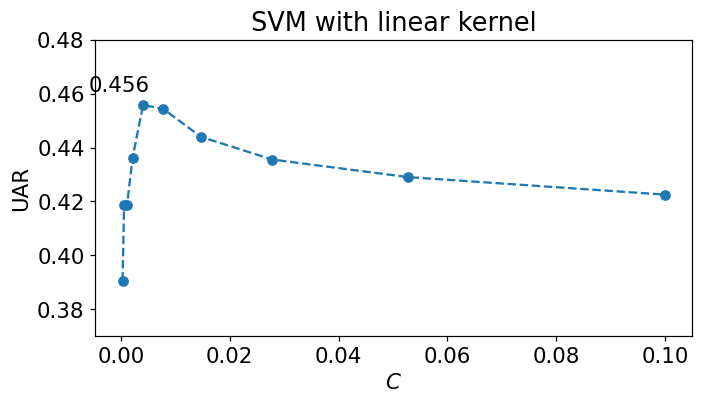

In [22]:
C = np.logspace(-3.5, -1.0, 10, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

# fig,ax=plt.subplots(figsize=(7,3.5))
# plt.rcParams.update({'font.size': 14})
# plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.ylim([0.37, 0.45])
# plt.xlabel('C')
# plt.ylabel('UAR')

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) # 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

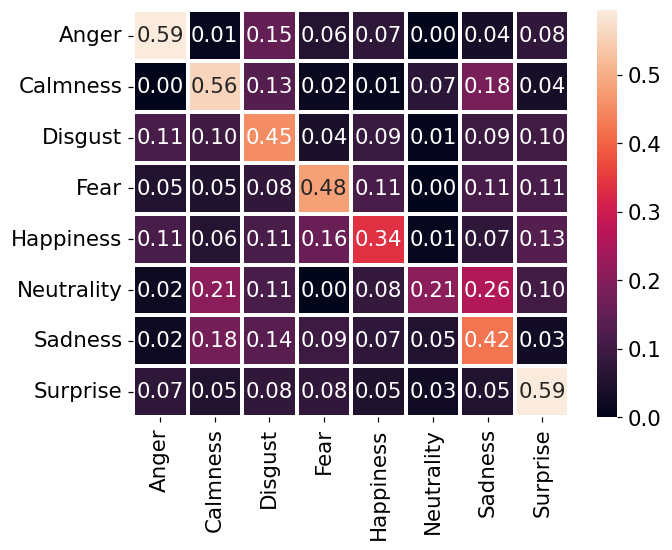

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [23]:
# Confusion matrix
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)

# 5-fold CV (selected feature space)

In [24]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm[:,feature_ind])
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

In [25]:
X_new

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-0.510118,0.091157,-0.125111,-0.084387,-0.343715,0.172226,-0.340691,0.507975,1.136402,2.445545,...,-0.119538,2.135482,2.942501,0.894185,0.892212,0.380173,0.221249,0.508042,2.370877,0.394309
1,-1.521874,-0.513553,1.343100,-0.153646,-0.223590,0.613144,-0.762145,-0.578013,0.712442,0.548283,...,-1.007184,-0.692026,-0.390967,-0.237366,-0.441723,-0.535415,-0.801057,-0.112864,0.743287,-0.672824
2,-0.572497,-0.435643,-0.256055,-0.911184,0.311040,0.981156,-0.826127,-0.276989,0.594105,0.747373,...,-0.898421,0.052468,0.321891,-0.232689,-0.457981,-0.220583,-0.828405,-3.309826,-0.225933,-0.616111
3,-1.842742,-0.365858,-0.107841,-1.575944,-0.494150,-0.562788,-0.165081,0.540148,0.547577,2.585145,...,-0.819889,-0.352790,0.347012,0.232946,0.620459,1.409550,2.175074,0.094915,0.009020,-0.287503
4,-0.689512,1.209200,0.020091,-0.645613,0.185140,0.343931,0.046708,1.195381,0.859079,1.463107,...,0.068126,-1.121724,0.133566,-0.567644,2.280111,2.452250,2.328255,0.194419,-0.142512,2.594397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-0.467109,-0.328484,0.642538,1.494971,-0.587185,0.995423,0.585410,1.267308,1.929130,0.146871,...,-0.330961,-1.003603,0.705902,-0.977227,-0.169409,0.341353,0.203350,0.502291,0.282218,2.826095
1436,0.733979,0.302839,0.246054,-0.894729,1.358758,-0.063867,0.095599,1.304799,-0.514948,0.103597,...,-0.443046,-0.327598,-0.108372,0.719022,1.594643,1.194091,1.865513,1.424132,0.745310,0.894283
1437,1.062587,0.545192,0.032885,1.108665,0.358425,0.205071,0.129536,1.806541,-0.014449,0.489027,...,-1.143447,-0.930886,-0.000766,0.042219,1.192193,1.202830,0.209277,0.917660,2.472505,0.343901
1438,-0.820105,-1.451104,-0.989785,1.432662,0.302992,1.012529,-0.580327,0.129659,0.708992,-1.208153,...,0.253313,-1.146169,-0.673900,-1.075314,-0.311454,0.090062,-0.480553,0.107728,5.355102,0.023455


## GridSearch

 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.61it/s]

UAR = 0.275


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.87it/s]

UAR = 0.279


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.40it/s]

UAR = 0.305


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.94it/s]

UAR = 0.316


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.11it/s]

UAR = 0.331


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.26it/s]

UAR = 0.338


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.54it/s]

UAR = 0.347


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.86it/s]

UAR = 0.359


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.07it/s]

UAR = 0.370


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.95it/s]

UAR = 0.378


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.65it/s]

UAR = 0.385


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.09it/s]

UAR = 0.394


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.25it/s]

UAR = 0.398


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.18it/s]

UAR = 0.409


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.01it/s]

UAR = 0.413


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.16it/s]

UAR = 0.419


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.43it/s]

UAR = 0.419


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.52it/s]

UAR = 0.418


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.72it/s]

UAR = 0.415


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.19it/s]

UAR = 0.415


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.41it/s]

UAR = 0.420


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.43it/s]

UAR = 0.419


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.47it/s]

UAR = 0.417


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.09it/s]

UAR = 0.416


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.58it/s]

UAR = 0.417


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.29it/s]

UAR = 0.417


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.01it/s]

UAR = 0.413


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.66it/s]

UAR = 0.412


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.58it/s]

UAR = 0.411


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.64it/s]

UAR = 0.414


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.78it/s]

UAR = 0.409


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.99it/s]

UAR = 0.410


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.76it/s]

UAR = 0.410


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.10it/s]

UAR = 0.403


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 11.73it/s]

UAR = 0.398


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.47it/s]

UAR = 0.398


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.61it/s]

UAR = 0.398


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.68it/s]

UAR = 0.391


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  6.37it/s]

UAR = 0.395


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


UAR = 0.391
UAR_best = 0.420, C_best = 0.020


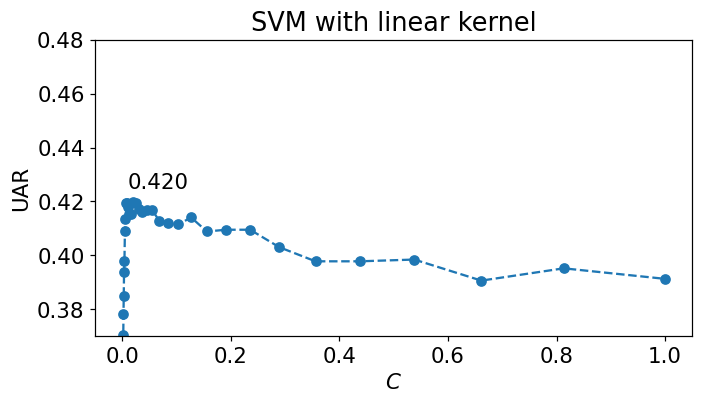

In [26]:
C = np.logspace(-3.5, -0.0, 40, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

## Confusion matrix

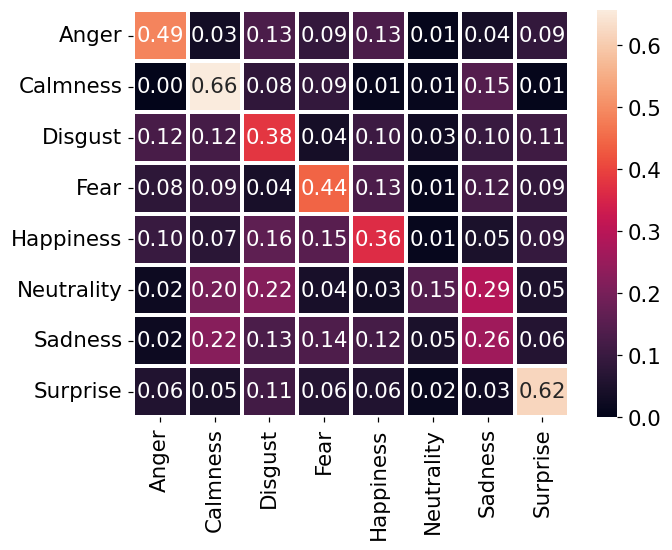

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [27]:
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)